In [151]:
import pandas as pd
import numpy as np

data = pd.read_pickle('../pkl_data/GRAPE.pkl')

octopus61_coords = np.array([
    (0,0), (1,-1), (-1,-1), (-1,1), (1,1), (2,-2), (-2,-2), (-2,2),
    (2,2), (4,-1), (4,-4), (1,-4), (-1,-4), (-4,-4), (-4,-1), (-4,1), (-4,4),
    (-1,4), (1,4), (4,4), (4,1), (6,0), (6,-6), (2,-6), (-2,-6), (-6,-6),
    (-6,-1), (-6,1), (-6,6), (-2,6), (2,6), (6,6), (8,-1), (8,-6), (8,-8), (6,-8), (2,-8), 
    (-2,-8), (-6,-8), (-8,-8), (-8,-6), (-8,-1), (-8,1), (-8,6), (-8,8), (-6,8), (-2,8), (2,8), (6,8),
    (8,8), (8,6), (8,1), (10,-3), (3,-10), (-3,-10), (-10, -2), (-10,2), (-3,10), (3,10), (10,3)
])


def create_lists(df):
    patients = []
    masks = []
    for i, row in df.iterrows():
        visits = []
        mask = []
        for val in row:
            if isinstance(val, float) and pd.isna(val):
                visits.append(np.full_like(df.iloc[0,0], np.nan, dtype=float))
                mask.append(0)
            else:
                visits.append(np.array(val, dtype=float))
                mask.append(1)
        patients.append(np.stack(visits))
        masks.append(np.array(mask, dtype=int))
    return np.array(patients, dtype=float), np.array(masks, dtype=int)




In [152]:
patients, masks = create_lists(data)

In [153]:
from sklearn.preprocessing import StandardScaler

flat = patients.reshape(-1, patients.shape[-1])
mask_flat = masks.reshape(-1, 1)


valid_rows = flat[mask_flat[:,0]==1]
scaler = StandardScaler()
scaler.fit(valid_rows)

flat_scaled = scaler.transform(flat)  #NaN are ignored
scaled_patients = flat_scaled.reshape(patients.shape)  #back to normal shape

In [154]:
from sklearn.decomposition import PCA
N, T, P = patients.shape
n = 7
pca = PCA(n_components=n)
pca.fit(valid_rows)
flat_visits_emb = pca.transform(np.nan_to_num(flat_scaled, nan=0.0))

visit_embeddings = flat_visits_emb.reshape(N, T, n)

diffs = np.diff(visit_embeddings, axis=1)
mean_slope = np.sum(diffs * masks[:,1:,None], axis=1) / np.sum(masks[:,1:], axis=1)[:,None]

mean_embedding = np.sum(visit_embeddings * masks[:, :, None], axis=1) / np.sum(masks, axis=1)[:, None]

# variance_embeddings = np.zeros((N, n))
# for i in range(N):
#     valid_visits = visit_embeddings[i][masks[i]==1]                   not helpful
#     if len(valid_visits) > 1:
#         variance_embeddings[i] = np.var(valid_visits, axis=0)
#     else:
#         variance_embeddings[i] = 0.0


patient_features = np.concatenate([mean_embedding, mean_slope], axis=1)


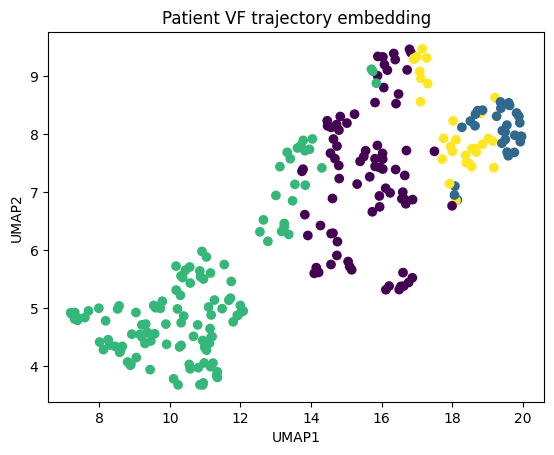

In [155]:
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(patient_features)

umap = UMAP(n_neighbors=8, min_dist=0.1)
embedding_2d = umap.fit_transform(patient_features)



plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c=labels)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Patient VF trajectory embedding")
plt.show()


In [156]:
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3], dtype=int32), array([ 80,  29, 124,  30]))


In [157]:
from sklearn.metrics import silhouette_score
score = silhouette_score(patient_features, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.2911033886972335


In [158]:
from sklearn.metrics import calinski_harabasz_score
score = calinski_harabasz_score(patient_features, labels)
print("CH Index:", score)

CH Index: 150.96014946625172


n = 7 and 4 clusters. mean_embedding, mean_slope only. Silhouette Score: 0.3003501843879679 and CH Index: 146.31354664512173

In [159]:
clusters = {}
for c in np.unique(labels):
    clusters[c] = np.where(labels == c)[0]

In [160]:
for c, idx in clusters.items():
    print(c, len(idx))

0 80
1 29
2 124
3 30


In [161]:
baseline_means = {
    c: np.nanmean(patients[idx, 0, :], axis=0)
    for c, idx in clusters.items()
}

In [162]:
from scipy.interpolate import Rbf

def plot_interpolated_vf(values, ax=None, cmap='viridis', title=None, vmin=None, vmax=None):
    """
    values: (60,) vector
    ax: matplotlib axis
    """
    coords = np.array([
    (0,0), (1,-1), (-1,-1), (-1,1), (1,1), (2,-2), (-2,-2), (-2,2),
    (2,2), (4,-1), (4,-4), (1,-4), (-1,-4), (-4,-4), (-4,-1), (-4,1), (-4,4),
    (-1,4), (1,4), (4,4), (4,1), (6,0), (6,-6), (2,-6), (-2,-6), (-6,-6),
    (-6,-1), (-6,1), (-6,6), (-2,6), (2,6), (6,6), (8,-1), (8,-6), (8,-8), (6,-8), (2,-8), 
    (-2,-8), (-6,-8), (-8,-8), (-8,-6), (-8,-1), (-8,1), (-8,6), (-8,8), (-6,8), (-2,8), (2,8), (6,8),
    (8,8), (8,6), (8,1), (10,-3), (3,-10), (-3,-10), (-10, -2), (-10,2), (-3,10), (3,10), (10,3)
    ])

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    grid_x, grid_y = np.mgrid[-12:12:200j, -12:12:200j] # interpolation grid

    rbf = Rbf(coords[:,0], coords[:,1], values, function='thin_plate')
    grid_z = rbf(grid_x, grid_y)

    radius = 12
    mask = np.sqrt(grid_x**2 + grid_y**2) <= radius     # circular mask
    masked_grid = np.where(mask, grid_z, np.nan)

    image = ax.imshow(masked_grid.T, extent=(-12, 12, -12, 12), origin='lower', cmap=cmap,
                      vmin = vmin, vmax = vmax) #plot

    ax.set_title(title if title else "")
    ax.axis('off')
    
    return image

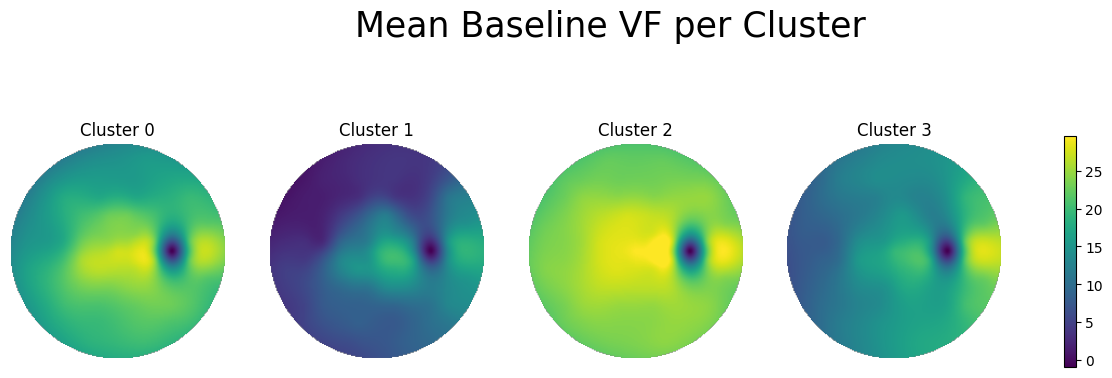

In [163]:
n_clusters = len(clusters)
fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 5))

all_vals = np.concatenate([baseline_means[c] for c in clusters])
vmin, vmax = all_vals.min(), all_vals.max()

for ax, c in zip(axes, clusters):
    values = baseline_means[c]
    im = plot_interpolated_vf(values, ax=ax,
                              cmap='viridis', title=f"Cluster {c}", vmin=vmin, vmax=vmax)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
fig.suptitle("Mean Baseline VF per Cluster", fontsize=25)
plt.show()

In [164]:
N, T, P = patients.shape
mean_slope_vf = np.zeros((N, P))

for i in range(N):
    valid_visits = patients[i][masks[i]==1]  # only real visits
    diffs = np.diff(valid_visits, axis=0)  # difference between consecutive visits
    mean_slope_vf[i] = np.mean(diffs, axis=0)  # average slope per VF location


cluster_slope_vf = {}
for c, idx in clusters.items():
    cluster_slope_vf[c] = np.mean(mean_slope_vf[idx], axis=0)


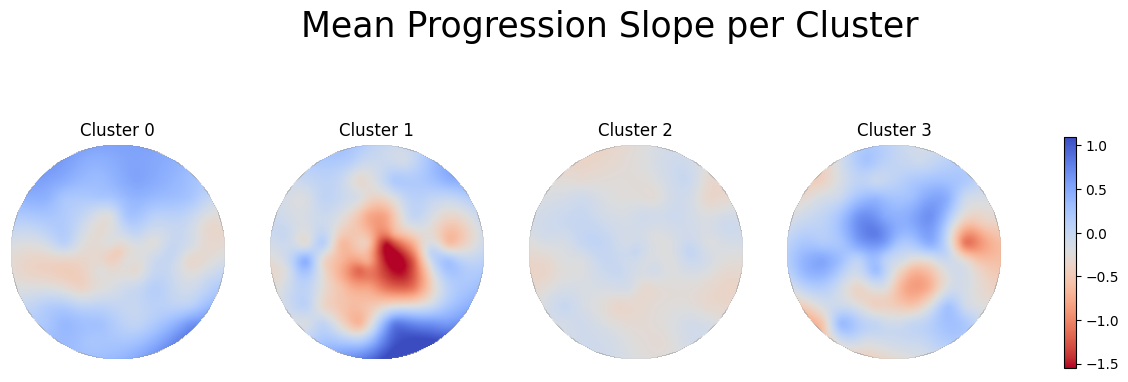

In [165]:
n_clusters = len(clusters)
fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 5))

all_vals = np.concatenate([cluster_slope_vf[c] for c in clusters])
vmin, vmax = all_vals.min(), all_vals.max()

for ax, c in zip(axes, clusters):
    values = cluster_slope_vf[c]
    im = plot_interpolated_vf(values, ax=ax,
                              cmap='coolwarm_r', title=f"Cluster {c}", vmin=vmin, vmax=vmax)

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
fig.suptitle("Mean Progression Slope per Cluster", fontsize=25)
plt.show()


In [166]:
def last_visit_per_patient(patients, masks):
    N, T, P = patients.shape
    last_visits = np.full((N, P), np.nan, dtype=float)
    for i in range(N):
        valid_idx = np.where(masks[i] == 1)[0]
        if valid_idx.size > 0:
            last_idx = valid_idx[-1]
            last_visits[i] = patients[i, last_idx]
    return last_visits

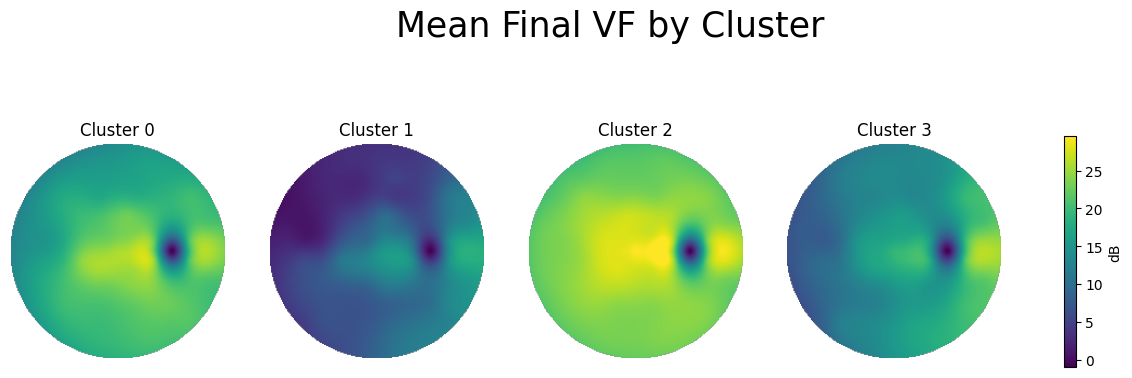

In [167]:
last_visits = last_visit_per_patient(patients, masks)

last_means = {
    c: np.nanmean(last_visits[idx], axis=0)
    for c, idx in clusters.items()
}

all_vals = np.concatenate([last_means[c] for c in clusters])
vmin, vmax = all_vals.min(), all_vals.max()


n_clusters = len(clusters)
fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 5))

for ax, c in zip(axes, clusters):
    vals = last_means[c]
    im = plot_interpolated_vf(vals, ax=ax, cmap='viridis',
                              title=f"Cluster {c}", vmin=vmin, vmax=vmax)

fig.colorbar(im, ax=axes, shrink=0.6, label='dB')
fig.suptitle("Mean Final VF by Cluster", fontsize=25)
plt.show()

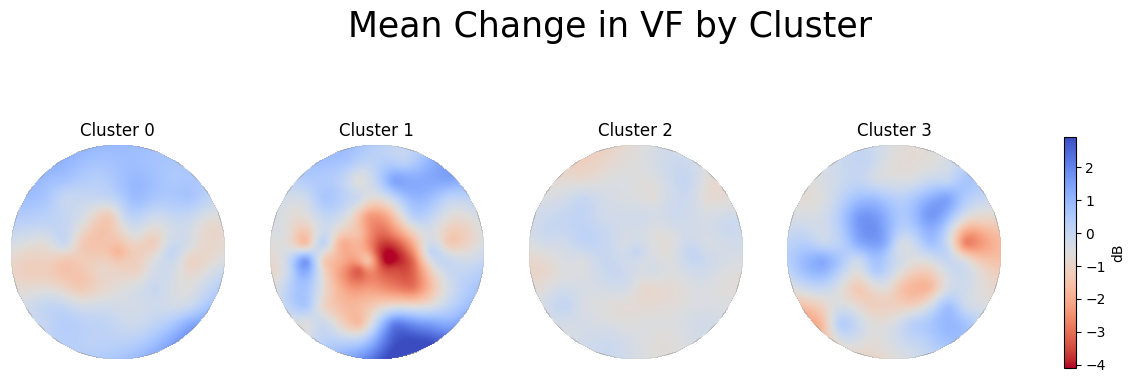

In [168]:
diff_means = {c: last_means[c]- baseline_means[c] for c in clusters.keys()}

all_vals = np.concatenate([diff_means[c] for c in clusters])
vmin, vmax = all_vals.min(), all_vals.max()


n_clusters = len(clusters)
fig, axes = plt.subplots(1, n_clusters, figsize=(4*n_clusters, 5))

for ax, c in zip(axes, clusters):
    vals = diff_means[c]
    im = plot_interpolated_vf(vals, ax=ax, cmap='coolwarm_r',
                              title=f"Cluster {c}", vmin=vmin, vmax=vmax)

fig.colorbar(im, ax=axes, shrink=0.6, label='dB')
fig.suptitle("Mean Change in VF by Cluster", fontsize=25)
plt.show()

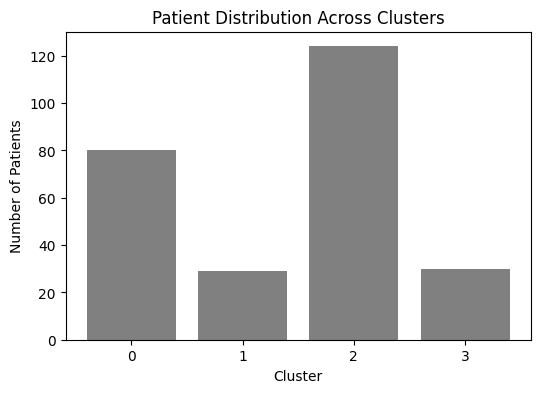

In [169]:
x_lab, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(x_lab, counts, color='grey')
plt.xlabel("Cluster")
plt.ylabel("Number of Patients")
plt.title("Patient Distribution Across Clusters")
plt.xticks(x_lab)
plt.show()

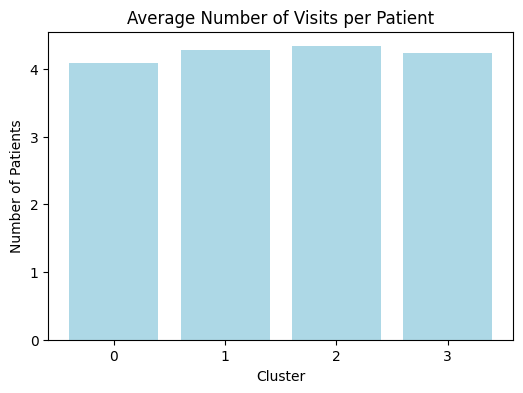

In [170]:
avg_visits = []
for c in x_lab:
    i = clusters[c]     # compute average visits per cluster
    avg_visits.append(masks[i].sum(axis=1).mean())


x_lab, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(x_lab, avg_visits, color='lightblue')
plt.xlabel("Cluster")
plt.ylabel("Number of Patients")
plt.title("Average Number of Visits per Patient")
plt.xticks(x_lab)
plt.show()